In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

import time
from glob import glob
from tqdm import tqdm
import os

import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras import backend as K
# from keras.utils import plot_model

from keras.layers import Activation, Dense, LSTM, GRU, Bidirectional, AveragePooling1D, GlobalAveragePooling1D, Dropout, Flatten, BatchNormalization, TimeDistributed, Input, Reshape, RepeatVector, Concatenate, GlobalMaxPooling1D 
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D


#GPU 자원이 부족
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [7]:
raw_data = pd.read_csv('/content/drive/MyDrive/신입기수 프로젝트/Dataset/newdata5.csv', encoding = 'cp949')
raw_data

광진교_수위 = pd.read_csv('/content/drive/MyDrive/신입기수 프로젝트/Dataset/cnn_광진.csv', encoding = 'UTF-8')
광진교_수위 = 광진교_수위['수위']

raw_data['광진교_수위'] = 광진교_수위
raw_data

,날짜,대곡교_강수량,진관교_강수량,송정동_강수량,서울시_강수량,방류량,강화대교_조위,청담대교_유량,한강대교_유량,행주대교_유량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위,광진교_수위
0,2012-05-01 0:00,0.0,0.0,0.0,0.0,575.70,193.0,469.05,729.80,540.18,310.7,300.2,290.0,275.3,1.20
1,2012-05-01 0:10,0.0,0.0,0.0,0.0,575.30,199.0,498.00,731.48,540.18,314.7,300.2,290.0,275.3,1.20
2,2012-05-01 0:20,0.0,0.0,0.0,0.0,555.00,207.0,490.68,726.42,540.18,313.7,301.2,290.0,275.3,1.20
3,2012-05-01 0:30,0.0,0.0,0.0,0.0,575.70,215.0,476.21,726.42,552.17,311.7,301.2,290.0,276.3,1.20
4,2012-05-01 0:40,0.0,0.0,0.0,0.0,575.40,226.0,476.21,707.17,564.29,311.7,301.2,291.0,277.3,1.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276331,2022-07-18 23:10,0.0,0.0,0.0,0.0,258.67,407.0,319.84,-456.41,974.40,288.0,295.0,299.0,306.0,1.12
276332,2022-07-18 23:20,0.0,0.0,0.0,0.0,258.58,431.0,314.01,-717.30,1006.88,287.0,303.0,304.0,308.0,1.12
276333,2022-07-18 23:30,0.0,0.0,0.0,0.0,258.56,453.0,387.55,-843.37,1039.90,299.0,307.0,309.0,310.0,1.12
276334,2022-07-18 23:40,0.0,0.0,0.0,0.0,258.65,476.0,454.91,-1023.37,1073.46,309.0,311.0,314.0,312.0,1.12


In [ ]:
input_y = raw_data[['한강대교_유량']]
raw_data_ = raw_data.drop(raw_data[['청담대교_유량', '날짜']], axis = 1)
input_x = raw_data_
input_x
# input_x = raw_data[['방류량', '강화대교_조위', '한강대교_유량', '행주대교_유량', '청담대교_수위', '잠수교_수위', '한강대교_수위', '행주대교_수위']]

,대곡교_강수량,진관교_강수량,송정동_강수량,서울시_강수량,방류량,강화대교_조위,한강대교_유량,행주대교_유량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
0,0.0,0.0,0.0,0.0,575.70,193.0,729.80,540.18,310.7,300.2,290.0,275.3
1,0.0,0.0,0.0,0.0,575.30,199.0,731.48,540.18,314.7,300.2,290.0,275.3
2,0.0,0.0,0.0,0.0,555.00,207.0,726.42,540.18,313.7,301.2,290.0,275.3
3,0.0,0.0,0.0,0.0,575.70,215.0,726.42,552.17,311.7,301.2,290.0,276.3
4,0.0,0.0,0.0,0.0,575.40,226.0,707.17,564.29,311.7,301.2,291.0,277.3
...,...,...,...,...,...,...,...,...,...,...,...,...
276331,0.0,0.0,0.0,0.0,258.67,407.0,-456.41,974.40,288.0,295.0,299.0,306.0
276332,0.0,0.0,0.0,0.0,258.58,431.0,-717.30,1006.88,287.0,303.0,304.0,308.0
276333,0.0,0.0,0.0,0.0,258.56,453.0,-843.37,1039.90,299.0,307.0,309.0,310.0
276334,0.0,0.0,0.0,0.0,258.65,476.0,-1023.37,1073.46,309.0,311.0,314.0,312.0


In [ ]:
# 6912개만큼의 y값 추가

# df수위last = pd.DataFrame()
# path = '/content/drive/MyDrive/신입기수 프로젝트/Dataset/submission 임시/*.csv'
# last수위 = sorted(glob(path))
# lst = ['청담대교_수위', '잠수교_수위', '한강대교_수위', '행주대교_수위']
# for i in range(len(last수위)):
#   df수위last[lst[i]] = pd.read_csv(last수위[i], encoding = 'cp949')

last수위_file = sorted(glob("/content/drive/MyDrive/신입기수 프로젝트/Dataset/submission 임시/*.csv"))
last수위 = []

for i in range(len(last수위_file)):
  tmp = pd.read_csv(last수위_file[i], encoding = 'cp949')
  last수위.append(np.array(tmp.iloc[:,1])*100)

In [ ]:
last수위 = np.array(last수위).reshape(6912, 4)
print(last수위.shape)

(6912, 4)


In [ ]:
input_x.iloc[-6912:, -4:] = last수위

In [ ]:
# 정규화
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

input_x_regular = input_x.copy()

for i in range(len(input_x.columns)):
    scaler = MinMaxScaler()                       #StandardScaler() , MinMaxScaler() , RobustScaler()
    a=np.array(input_x_regular.iloc[:,i])
    tmp_x = scaler.fit_transform(a.reshape(-1,1))
    input_x_regular.iloc[:,i] = tmp_x

input_regular = pd.concat([input_x_regular, input_y], axis = 1)
input_regular

,대곡교_강수량,진관교_강수량,송정동_강수량,서울시_강수량,방류량,강화대교_조위,한강대교_유량,행주대교_유량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위,청담대교_유량
0,0.0,0.0,0.0,0.0,0.058462,0.191781,0.147596,0.011070,0.063009,0.060209,0.052758,0.050096,469.05
1,0.0,0.0,0.0,0.0,0.058447,0.199253,0.147654,0.011070,0.066846,0.060209,0.052758,0.050096,498.00
2,0.0,0.0,0.0,0.0,0.057689,0.209215,0.147478,0.011070,0.065887,0.061320,0.052758,0.050096,490.68
3,0.0,0.0,0.0,0.0,0.058462,0.219178,0.147478,0.011475,0.063969,0.061320,0.052758,0.051569,476.21
4,0.0,0.0,0.0,0.0,0.058451,0.232877,0.146810,0.011883,0.063969,0.061320,0.053957,0.053043,476.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...
276331,0.0,0.0,0.0,0.0,0.046624,0.458281,0.106425,0.025719,0.028771,0.031104,0.032374,0.045234,319.84
276332,0.0,0.0,0.0,0.0,0.046621,0.488169,0.097370,0.026815,0.025894,0.028882,0.031175,0.045234,314.01
276333,0.0,0.0,0.0,0.0,0.046620,0.515567,0.092994,0.027929,0.025894,0.027772,0.035971,0.068808,387.55
276334,0.0,0.0,0.0,0.0,0.046624,0.544209,0.086747,0.029061,0.047952,0.058876,0.068345,0.095329,454.91


In [ ]:
xdata = []
ydata = []
xdata_idx = []
ydata_idx = [-4,-3,-2,-1]
for i in range(len(input_regular.columns)-4):
    xdata_idx.append(i)

In [ ]:
xdata = input_x_regular
ydata = input_regular['청담대교_유량']

# train data 설정

In [ ]:
rawdata = pd.read_csv('/content/drive/MyDrive/신입기수 프로젝트/Dataset/rawdata.csv')


In [ ]:
nanIndex = rawdata[rawdata['청담대교_유량'].isnull() == True].index

In [ ]:
nanIndex

Int64Index([ 80994,  80995,  80996,  80997,  80998,  80999,  81000,  81001,
             81002,  81003,
            ...
            273770, 273771, 273772, 273773, 273774, 273775, 273776, 273777,
            273778, 273779],
           dtype='int64', length=16380)

In [ ]:
w = 6
y_predict = []

xtrain = []
ytrain = []

for i in tqdm(range(len(xdata)-w)):
    xtrain.append(np.array(xdata.iloc[i:i + w, :]).astype(float))

for i in tqdm(range(w, len(xdata))):
  ytrain.append(np.array(ydata[i]).astype(float))

100%|██████████| 276330/276330 [00:00<00:00, 295577.28it/s]


In [ ]:
print(np.array(xtrain).shape)
print(np.array(ytrain).shape)

(276330, 6, 12)
(276330,)


In [ ]:
# 나중에 학습된 모델에 이거 넣어서 predict해서 결측치 채우기
x_real_predict = []
y_real_predict = []

for i in range(len(nanIndex)):
  k = nanIndex[-(i+1)]
      
  x_real_predict.insert(0, (xtrain[k-w]))
  y_real_predict.insert(0, (ytrain[k-w]))

  xtrain.pop(k-w)
  ytrain.pop(k-w)

In [ ]:
print(np.array(xtrain).shape)
print(np.array(ytrain).shape)

(259950, 6, 12)
(259950,)


In [ ]:
276330 - 259950 == len(nanIndex)

True

In [ ]:
pd.DataFrame(ytrain).isnull().sum()

0    0
dtype: int64

In [ ]:
xtrain = np.array(xtrain[:-50000])
ytrain = np.array(ytrain[:-50000]).reshape(len(xtrain), 1)

xtest = np.array(xtrain[-50000:])
ytest = np.array(ytrain[-50000:]).reshape(len(xtest), 1)

In [ ]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(209950, 6, 12)
(209950, 1)
(50000, 6, 12)
(50000, 1)


## 모델 정의

In [ ]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [ ]:
if 'model_enc_dec_cnn' in locals(): 
    del model_enc_dec_cnn 
if 'history' in locals():
    del history

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=0.01) #기본값 0.001

In [ ]:
model_enc_dec_cnn = Sequential()
model_enc_dec_cnn.add(Conv1D(filters=32, kernel_size=4, activation='relu', input_shape=(w, xtrain.shape[2])))
model_enc_dec_cnn.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
model_enc_dec_cnn.add(Flatten())

model_enc_dec_cnn.add(RepeatVector(1))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu'))

model_enc_dec_cnn.add(Dense(100, activation='relu'))
model_enc_dec_cnn.add(Dense(1))

model_enc_dec_cnn.compile(loss=root_mean_squared_error, optimizer=optimizer, metrics =["accuracy"])

In [ ]:
model_enc_dec_cnn.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_19 (Conv1D)          (None, 3, 32)             1568      
                                                                 
 conv1d_20 (Conv1D)          (None, 2, 32)             2080      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1, 32)            0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 32)                0         
                                                                 
 repeat_vector_2 (RepeatVect  (None, 1, 32)            0         
 or)                                                             
                                                                 
 lstm_4 (LSTM)               (None, 1, 200)          

In [ ]:
epochs = 100
batch_size = xtrain.shape[0] // 1000
validation = 0.2

checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', save_weights_only=False, monitor='val_loss',
                                         mode='min', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, mode='min')
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min', patience=3, min_lr=0.001)

In [ ]:
history = model_enc_dec_cnn.fit(xtrain, ytrain, verbose=1, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])

Epoch 1/100
804/804 [==============================] - 22s 24ms/step - loss: 913.7647 - accuracy: 0.0000e+00 - val_loss: 446.1669 - val_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 2/100
804/804 [==============================] - 19s 24ms/step - loss: 898.5158 - accuracy: 0.0000e+00 - val_loss: 432.6140 - val_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 3/100
804/804 [==============================] - 19s 24ms/step - loss: 896.8179 - accuracy: 0.0000e+00 - val_loss: 420.6859 - val_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 4/100
804/804 [==============================] - 19s 24ms/step - loss: 895.3293 - accuracy: 0.0000e+00 - val_loss: 436.1299 - val_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 5/100
804/804 [==============================] - 19s 24ms/step - loss: 895.7087 - accuracy: 0.0000e+00 - val_loss: 468.8426 - val_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 6/100
804/804 [==============================] - 19s 24ms/step - loss: 896.1765 - accuracy: 0.0000e+00 - val_loss: 440.2919 - val_accuracy: 0.00

In [ ]:
keras_model_best = keras.models.load_model('best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error})

yhat = keras_model_best.predict(xtest, verbose=1)

yhat

keras_model_best.evaluate(xtest,ytest)

1563/1563 [==============================] - 5s 3ms/step - loss: 407.3681 - accuracy: 0.0000e+00


[407.3681335449219, 0.0]

In [ ]:
test_input = np.array(x_real_predict)
y_real_hat = keras_model_best.predict(test_input, verbose=1)

512/512 [==============================] - 1s 3ms/step


In [ ]:
for i in range(len(nanIndex)):
    raw_data.iloc[nanIndex[i], 7] = np.float64(y_real_hat[i])

In [ ]:
print(len(y_real_predict))


16380


In [ ]:
raw_data.to_csv('/content/drive/MyDrive/신입기수 프로젝트/Dataset/newdata5.csv', encoding = 'cp949', index = False)

In [ ]:
input_regular.iloc[273671:273780]

,방류량,강화대교_조위,한강대교_유량,행주대교_유량,청담대교_유량
날짜,,,,,
2022-06-30 11:50:00,0.287933,0.748443,0.448742,0.282213,9509.8490
2022-06-30 12:00:00,0.290992,0.732254,0.450169,0.283862,9612.1170
2022-06-30 12:10:00,0.290829,0.713574,0.452892,0.283862,9691.8390
2022-06-30 12:20:00,0.293626,0.696139,0.455990,0.285517,9735.4680
2022-06-30 12:30:00,0.295885,0.674969,0.461891,0.287177,9763.1750
...,...,...,...,...,...
2022-07-01 05:10:00,0.288714,0.249066,0.451718,0.290510,9921.5240
2022-07-01 05:20:00,0.289160,0.237858,0.447515,0.285517,9797.9960
2022-07-01 05:30:00,0.289399,0.231631,0.443383,0.282213,9688.8240


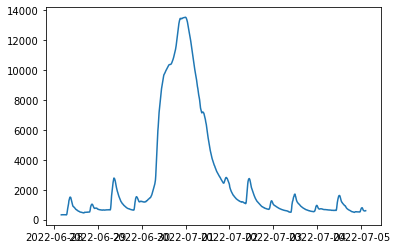

In [ ]:
plt.plot(input_regular[-3000:-2000]['청담대교_유량'])

In [ ]:
xdata = []
ydata = []
xdata_idx = []
ydata_idx = [-1]
for i in range(len(input_regular.columns)-1):
    xdata_idx.append(i)

w =  432 #window size

idx = []
for i in range(12):
  idx.append(i*26496)

for i in tqdm(range(11)):
    if i != 10:
        tmp = input_regular[idx[i]:idx[i+1]]
    else:
        tmp = input_regular[idx[i]:]

    for j in range(len(tmp)-w):
        xdata.append(np.array(tmp.iloc[j:j + w, xdata_idx]).astype(float))

    for j in range(w,len(tmp)):
        ydata.append(np.array(tmp.iloc[j, ydata_idx]).astype(float))



100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:52<00:00,  4.79s/it]


In [ ]:
xtrain = np.array(xdata[:268919] + xdata[269028:])
ytrain = np.array(ydata[:268919] + ydata[269028:])

xtest = np.array(xdata[268919:269028])
ytest = np.array(ydata[268919:269028])

In [ ]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(271475, 432, 4)
(271475, 1)
(109, 432, 4)
(109, 1)


In [ ]:
def inverse_transform(y_test, yhat):
     y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
     yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])
     yhat_inverse = scaler.inverse_transform(yhat_reshaped)
     y_test_inverse = scaler.inverse_transform(y_test_reshaped)
     return yhat_inverse, y_test_inverse

def evaluate_forecast(y_test_inverse, yhat_inverse):
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    rmse = np.sqrt(mae_(y_test_inverse,yhat_inverse))
    print('rmse:', rmse)
    mse = mse_(y_test_inverse,yhat_inverse)
    print('mse:', mse)
    mape = mape_(y_test_inverse,yhat_inverse)
    print('mape:', mape)

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

optimizer = tf.keras.optimizers.Adam(lr=0.01) #기본값 0.001

In [ ]:
"""
if 'model_enc_dec_cnn' in locals(): 
    del model_enc_dec_cnn 
if 'history' in locals():
    del history
"""

"\nif 'model_enc_dec_cnn' in locals(): \n    del model_enc_dec_cnn \nif 'history' in locals():\n    del history\n"

In [ ]:
model_enc_dec_cnn = Sequential()
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=9, activation='relu', input_shape=(w, xtrain.shape[2])))
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model_enc_dec_cnn.add(AveragePooling1D(pool_size=2))
model_enc_dec_cnn.add(Flatten())
#model_enc_dec_cnn.add(GlobalMaxPooling1D())

model_enc_dec_cnn.add(RepeatVector(1))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu'))

model_enc_dec_cnn.add(Dense(100, activation='relu'))
model_enc_dec_cnn.add(Dense(4))
#model_enc_dec_cnn.add(TimeDistributed(Dense(100, activation='relu')))
#model_enc_dec_cnn.add(TimeDistributed(Dense(4)))

model_enc_dec_cnn.compile(loss=root_mean_squared_error, optimizer=optimizer, metrics =["accuracy"])

In [ ]:
model_enc_dec_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 424, 64)           2368      
                                                                 
 conv1d_1 (Conv1D)           (None, 414, 64)           45120     
                                                                 
 average_pooling1d (AverageP  (None, 207, 64)          0         
 ooling1D)                                                       
                                                                 
 flatten (Flatten)           (None, 13248)             0         
                                                                 
 repeat_vector (RepeatVector  (None, 1, 13248)         0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 200)               1

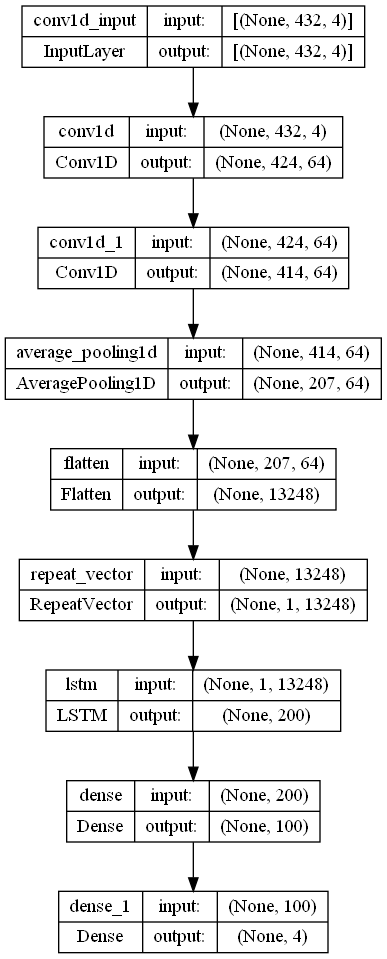

In [ ]:
plot_model(model=model_enc_dec_cnn, show_shapes=True)

In [ ]:
epochs = 100
batch_size = 256
validation = 0.2

checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', save_weights_only=False, monitor='val_loss',
                                         mode='min', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, mode='min')
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min', patience=3, min_lr=0.001)

history = model_enc_dec_cnn.fit(xtrain, ytrain, verbose=1, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])

Epoch 1/100
849/849 [==============================] - 331s 389ms/step - loss: 229.6090 - accuracy: 0.0000e+00 - val_loss: 131.9829 - val_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 2/100
849/849 [==============================] - 334s 394ms/step - loss: 124.4909 - accuracy: 0.0000e+00 - val_loss: 96.2167 - val_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 3/100
849/849 [==============================] - 332s 391ms/step - loss: 102.3205 - accuracy: 0.0000e+00 - val_loss: 187.7074 - val_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 4/100
849/849 [==============================] - 339s 399ms/step - loss: 93.0696 - accuracy: 0.0000e+00 - val_loss: 91.4988 - val_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 5/100
849/849 [==============================] - 333s 392ms/step - loss: 85.5125 - accuracy: 0.0000e+00 - val_loss: 88.9180 - val_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 6/100
849/849 [==============================] - 336s 396ms/step - loss: 79.6903 - accuracy: 0.0000e+00 - val_loss: 135.9187 - val_accuracy

In [ ]:
keras_model_best = keras.models.load_model('best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error})

yhat = keras_model_best.predict(xtest, verbose=1)

yhat

yhat_inverse, y_test_inverse = inverse_transform(ytest, yhat)
evaluate_forecast(y_test_inverse, yhat_inverse)

keras_model_best.evaluate(xtest,ytest)

4/4 [==============================] - 0s 28ms/step
rmse: 4818.6743
mse: tf.Tensor(784963460000000.0, shape=(), dtype=float32)
mape: tf.Tensor(6.3916936, shape=(), dtype=float32)
4/4 [==============================] - 1s 17ms/step - loss: 838.2095 - accuracy: 0.0000e+00


[838.2095336914062, 0.0]

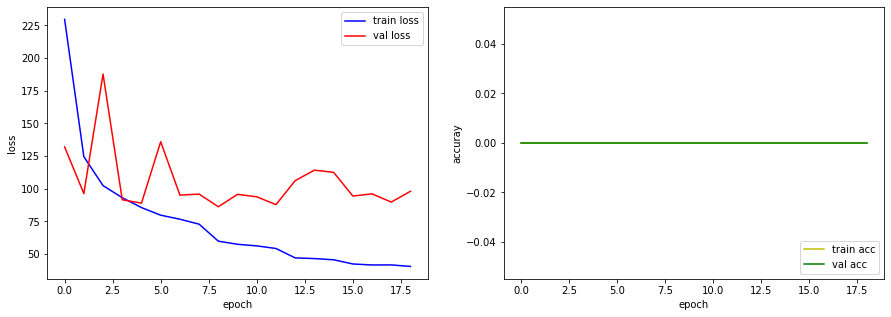

In [ ]:
#학습 과정 표시하기
%matplotlib inline
fig, loss_ax = plt.subplots(1, 2)
fig.set_size_inches((15,5))

loss_ax[0].plot(history.history['loss'], 'b', label='train loss')
loss_ax[0].plot(history.history['val_loss'], 'r', label='val loss')

loss_ax[1].plot(history.history['accuracy'], 'y', label='train acc')
loss_ax[1].plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax[0].set_xlabel('epoch')
loss_ax[0].set_ylabel('loss')
loss_ax[1].set_xlabel('epoch')
loss_ax[1].set_ylabel('accuray')

loss_ax[0].legend(loc='upper right')
loss_ax[1].legend(loc='lower right')

plt.show()

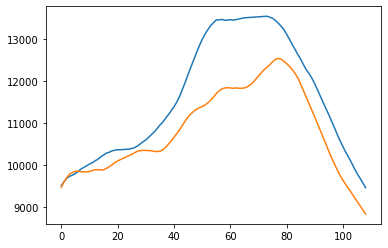

In [ ]:
tl_predict = np.array(yhat).T

#결과 시각화
plt.plot(ytest.reshape(-1))
plt.plot(tl_predict[0])

In [ ]:
plt.plot(tl_predict[0])

NameError: ignored

In [ ]:
tl_predict.shape

(4, 109)

In [ ]:
plt.plot(ydata['청담대교_수위'].iloc[273671:273780])

TypeError: list indices must be integers or slices, not str

In [ ]:
ytest__['청담대교_수위'][273671:273780]

TypeError: list indices must be integers or slices, not str

In [ ]:
ytest_list = sorted(glob("C:/Users/sjkan/Desktop/submission 임시/*.csv"))
ytest__ = []

for i in range(len(ytest_list)):
  tmp = pd.read_csv(ytest_list[i], encoding = 'cp949', usecols=[0])
  ytest__.append(np.array(tmp.iloc[:,1])*100)

IndexError: single positional indexer is out-of-bounds

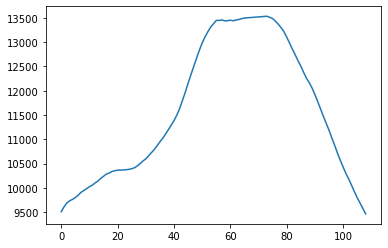

In [ ]:
plt.plot(pd.DataFrame(ytest).loc[:,0])

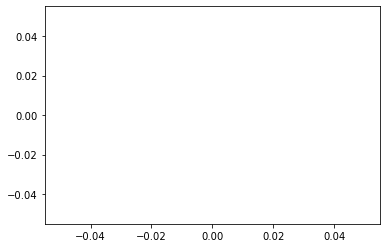

In [ ]:
plt.plot(np.array(ytest__).T[273671:273780])

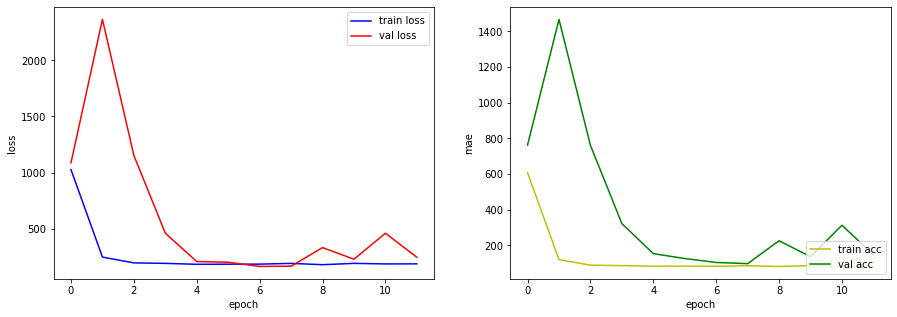

In [ ]:
#점수 채점하기
score = []
for i in range(4):
    print(root_mean_squared_error(ytest_[i], tl_predict[i]))
    score.append(root_mean_squared_error(ytest_[i], tl_predict[i]))
    
print("최종점수: ", np.mean(score))

In [ ]:
#제출 파일 생성

sample_submission = pd.read_csv("C:/Users/sjkan/Desktop/연세/YBIGTA/22 여름방학/신입기수프로젝트/sample_submission.csv")

sample_submission["wl_1018662"] = tl_predict[0]
#sample_submission["wl_1018680"] = tl_predict[1]
#sample_submission["wl_1018683"] = tl_predict[2]
#sample_submission["wl_1019630"] = tl_predict[3]

sample_submission.to_csv("0824 청담대교 유량.csv", index = False)

ValueError: Length of values (109) does not match length of index (6912)

In [ ]:
pd.DataFrame(tl_predict).T.to_csv('0824 청담대교 결측치 cnnlstm.csv', encoding = 'cp949')

In [ ]:
pd.DataFrame(tl_predict).T

,0,1,2,3
0,9475.999023,9459.795898,9472.609375,9449.036133
1,9603.151367,9586.803711,9601.774414,9574.742188
2,9712.863281,9696.363281,9713.487305,9682.821289
3,9785.803711,9769.937500,9788.685547,9755.486328
4,9826.315430,9812.200195,9828.520508,9800.446289
...,...,...,...,...
104,9235.555664,9236.968750,9231.488281,9242.122070
105,9136.816406,9138.067383,9133.453125,9143.390625
106,9036.924805,9038.045898,9034.308594,9043.583984
107,8937.915039,8938.934570,8936.090820,8944.737305
